In [84]:
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions



import matplotlib.pyplot as plt


import numpy as np

# Keras Image Data Loading
ref: https://keras.io/api/data_loading/image/

In [27]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [87]:

def create_dataset(data_dir, shuffle=True):
    # Use ImageDataGenerator for normalization
    datagen = ImageDataGenerator(rescale=1./255)

    # Create a TensorFlow dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        image_size=(224, 224),
        shuffle=shuffle,
        seed=42,
        validation_split=0.2,
        subset="training",
        interpolation="bilinear",
        crop_to_aspect_ratio=True
    )

    val_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        image_size=(224, 224),
        shuffle=shuffle,
        seed=42,
        validation_split=0.1,
        subset="validation",
        interpolation="bilinear",
        crop_to_aspect_ratio=True
    )

    # Determine batch size dynamically
    #batch_size = tf.data.experimental.cardinality(train_dataset).numpy()
    #print(f"Using batch size: {batch_size}")

    # Apply data augmentation and normalization to the training set
    def augment_data(x, y):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        x = tf.image.random_brightness(x, max_delta=0.2)
        x = tf.image.random_contrast(x, lower=0.8, upper=1.2)
        x = datagen.standardize(x)  # Normalization

        # One-hot encode the labels
        #y = tf.one_hot(y, depth=5)


        return x, y

    train_dataset = train_dataset.map(augment_data)

    return train_dataset, val_dataset


In [88]:
# Example usage:
data_directory = 'Pollen_RawData/'

train_dataset,val_dataset = create_dataset(data_directory, shuffle=True)

# Now, you can use the train_dataset for training your model

Found 1034 files belonging to 5 classes.
Using 828 files for training.
Found 1034 files belonging to 5 classes.
Using 103 files for validation.


# Resnet Classification Training
ref: https://keras.io/guides/transfer_learning/#build-a-model

In [80]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [92]:
from keras.applications import ResNet101V2
from keras import models, layers, optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.utils import to_categorical

def train_model(train_dataset, val_dataset, num_classes, epochs=10, batch_size=32):
    # Load the pre-trained ResNet50 model
    base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False
        
    # Create a new model for transfer learning
    model = models.Sequential()

    # Add the pre-trained ResNet50 model
    model.add(base_model)

    # Flatten the output of the ResNet50 model
    model.add(layers.Flatten())

    # Add your own fully connected layers for classification
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Categorical classification

    # Compile the model with Adam optimizer & slow learning rate
    optimizer = optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])
    
    # Callback to adjust learning rate during training
    def lr_schedule(epoch):
        initial_lr = 1e-4
        decay_factor = 0.9
        lr = initial_lr * (decay_factor ** epoch)
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Callback to log data for TensorBoard
    tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_images=True)
    
    model.summary()
    # Train the model
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[lr_scheduler, tensorboard_callback])

    return model, history


In [ ]:
# Assuming you have already created train_dataset and val_dataset using create_dataset

#5 Output Neurons 
trained_model, training_history = train_model(train_dataset, val_dataset, epochs=10,num_classes=5)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten_17 (Flatten)        (None, 100352)            0         
                                                                 
 dense_51 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_52 (Dense)            (None, 256)               131328    
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 5)               

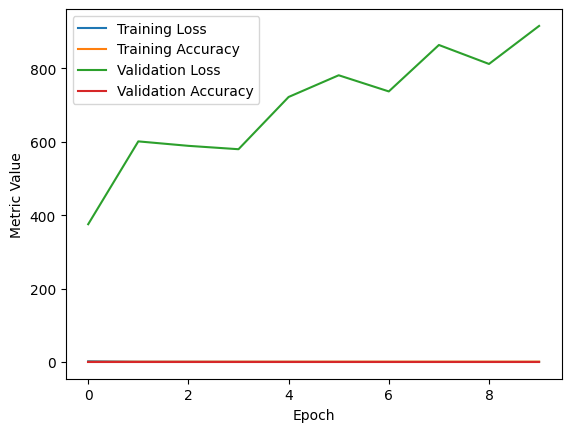

In [91]:
import matplotlib.pyplot as plt

# Assuming you've trained your model using model.fit(...) and stored the result in 'history'


# Plot training history
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()